# Importation des bibliothèques nécessaires
Cette cellule télécharge les ensembles de données et les modèles requis.

In [ ]:

import kagglehub
hajarkouch_books_dataset_path = kagglehub.dataset_download('hajarkouch/books-dataset')
hajarkouch_metadata_path = kagglehub.dataset_download('hajarkouch/metadata')
imanrlaaraj_data_amazon_path = kagglehub.dataset_download('imanrlaaraj/data-amazon')
imanrlaaraj_kguienhanced_pytorch_default_1_path = kagglehub.model_download('imanrlaaraj/kguienhanced/PyTorch/default/1')

print('Data source import complete.')


# Chargement des données
Cette cellule charge les données nécessaires à partir d'un fichier.

In [ ]:
import torch

data = torch.load(
    "/kaggle/input/data-amazon/amazon_kgcfrec_total_data.pt",
    map_location="cpu",
    weights_only=False
)

print("Fichier chargé avec succès ! ✅")


Fichier chargé avec succès ! ✅


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Inspection des données
Cette cellule affiche les clés et les types des données chargées.

In [ ]:
print("\nCLÉ (Nom du variable)     | TYPE            | DÉTAIL / FORME")
print("-" * 70)

for key, value in data.items():
    if torch.is_tensor(value):
        print(f"{key:<25} | Tensor          | Shape: {list(value.shape)}")
    elif isinstance(value, dict):
        print(f"{key:<25} | dict            | Dict len: {len(value)}")
    else:
        print(f"{key:<25} | {type(value).__name__:<15} | {value}")



CLÉ (Nom du variable)     | TYPE            | DÉTAIL / FORME
----------------------------------------------------------------------
num_nodes                 | int             | 691559
num_users                 | int             | 392089
num_items                 | int             | 215039
num_relations             | int             | 4
edge_index_train          | Tensor          | Shape: [2, 19082728]
edge_index_val            | Tensor          | Shape: [2, 1001580]
edge_index_test           | Tensor          | Shape: [2, 1001580]
edge_index_kg             | Tensor          | Shape: [2, 5463300]
edge_type_kg              | Tensor          | Shape: [5463300]
user_encoder              | LabelEncoder    | LabelEncoder()
item_encoder              | LabelEncoder    | LabelEncoder()
entity_encoder            | LabelEncoder    | LabelEncoder()
relation_dict             | dict            | Dict len: 4


# Vérifications rapides
Cette cellule vérifie la cohérence des indices dans les données.

In [ ]:
print("\n--- Vérifications Rapides ---")

num_nodes = data["num_nodes"]
edge_index_train = data["edge_index_train"]

max_index = edge_index_train.max().item()

print("Total Nœuds déclarés :", num_nodes)
print("Indice Max dans Train :", max_index)

if max_index < num_nodes:
    print("Cohérence des indices : OK ✅")
else:
    print("⚠️ Problème : indices hors limite")



--- Vérifications Rapides ---
Total Nœuds déclarés : 691559
Indice Max dans Train : 607127
Cohérence des indices : OK ✅


# Statistiques des utilisateurs et des éléments
Cette cellule affiche des statistiques sur les utilisateurs, les éléments et les relations.

In [ ]:
num_users = data["num_users"]
num_items = data["num_items"]
num_relations = data["num_relations"]
entity_encoder = data["entity_encoder"]

edge_index_kg = data["edge_index_kg"]
edge_type_kg = data["edge_type_kg"]

print("Users :", num_users)
print("Items :", num_items)
print("Relations KG :", num_relations)
print("Edges KG :", edge_index_kg.shape[1])


Users : 392089
Items : 215039
Relations KG : 4
Edges KG : 5463300


# Préparation des graphes
Cette cellule prépare les graphes pour l'entraînement.

In [ ]:
num_users = data["num_users"]
num_items = data["num_items"]
num_nodes = data["num_nodes"]
num_relations = data["num_relations"]

edge_index_ui = data["edge_index_train"]
edge_index_kg = data["edge_index_kg"]
edge_type_kg = data["edge_type_kg"]
edge_index_val= data["edge_index_val"]
edge_index_test= data["edge_index_test"]


# 2️⃣ FORCER le graphe sur CPU (TRÈS IMPORTANT)
edge_index_ui = edge_index_ui.cpu()
edge_index_kg = edge_index_kg.cpu()
edge_type_kg = edge_type_kg.cpu()


# Configuration de l'environnement
Cette cellule configure l'environnement pour l'entraînement.

In [ ]:
import os
# Configuration mémoire
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
import numpy as np
from torch.cuda.amp import GradScaler
from torch import amp
from collections import defaultdict
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Device utilisé : {device}")

# =========================================================
# 1. FONCTION D'ÉVALUATION (Identique)
# =========================================================

def evaluate(model, edge_ui, edge_kg, type_kg, ui_norm, kg_norm, test_edges, num_nodes, k=20, desc="Test"):
    """
    Évalue le modèle. desc sert juste à l'affichage (Validation ou Test Final).
    """
    model.eval()

    with torch.no_grad():
        all_emb = model(edge_ui, edge_kg, type_kg, ui_norm, kg_norm)

    users = test_edges[0].cpu().numpy()
    items = test_edges[1].cpu().numpy()

    hits = 0
    ndcgs = 0
    count = 0

    BATCH_SIZE_TEST = 1024
    num_samples = len(users)

    print(f"   🧪 [{desc}] Évaluation sur {num_samples} interactions...")

    with torch.no_grad():
        for i in range(0, num_samples, BATCH_SIZE_TEST):
            end = min(i + BATCH_SIZE_TEST, num_samples)

            batch_users = torch.tensor(users[i:end], device=device)
            batch_pos = torch.tensor(items[i:end], device=device)
            current_batch_size = len(batch_users)

            # 1 Positif vs 99 Négatifs
            negatives = torch.randint(0, num_nodes, (current_batch_size, 99), device=device)
            candidates = torch.cat([batch_pos.view(-1, 1), negatives], dim=1)

            user_emb = all_emb[batch_users].unsqueeze(1)
            item_emb = all_emb[candidates]
            scores = (user_emb * item_emb).sum(dim=2)

            _, indices = torch.topk(scores, k=k)
            indices = indices.cpu().numpy()

            for j in range(current_batch_size):
                rank_list = indices[j]
                if 0 in rank_list:
                    hits += 1
                    rank_index = np.where(rank_list == 0)[0][0]
                    ndcgs += 1.0 / np.log2(rank_index + 2)

            count += current_batch_size

    hr = hits / count
    ndcg = ndcgs / count
    recall = hr

    return hr, ndcg, recall

# =========================================================
# 2. DATA UTILS (MODIFIÉ POUR SPLIT TRAIN/VAL/TEST)
# =========================================================

def smart_reindex_dataset(data, keep_ratio=0.5):
    """
    Crée 3 sets : Train, Val (5000), Test (10%).
    """
    print(f"\n✂️ --- PRÉPARATION DATASET (Ratio global: {keep_ratio}) ---")

    # 1. Sampling global
    edge_index = data["edge_index_train"]
    num_edges_ui = edge_index.shape[1]
    perm = torch.randperm(num_edges_ui)
    keep_indices = perm[:int(num_edges_ui * keep_ratio)]
    subset_ui = edge_index[:, keep_indices]

    # 2. Sampling KG
    subset_kg = torch.empty((2, 0), dtype=torch.long)
    subset_kg_type = torch.empty((0,), dtype=torch.long)

    if hasattr(data, "edge_index_kg") and data["edge_index_kg"] is not None:
        kg_idx = data["edge_index_kg"]
        if kg_idx.shape[1] > 0:
            num_kg = kg_idx.shape[1]
            perm_kg = torch.randperm(num_kg)
            keep_kg = perm_kg[:int(num_kg * (keep_ratio * 0.8))]
            subset_kg = kg_idx[:, keep_kg]
            if hasattr(data, "edge_type_kg"):
                subset_kg_type = data["edge_type_kg"][keep_kg]

    # 3. Mapping
    print("   🔄 Mapping des indices...")
    all_nodes = torch.cat([subset_ui.flatten(), subset_kg.flatten()])
    unique_nodes, inverse_indices = torch.unique(all_nodes, return_inverse=True)

    len_ui = subset_ui.numel()
    data["edge_index_train"] = inverse_indices[:len_ui].view(2, -1)

    if subset_kg.numel() > 0:
        data["edge_index_kg"] = inverse_indices[len_ui:].view(2, -1)
        data["edge_type_kg"] = subset_kg_type
    else:
        data["edge_index_kg"] = torch.empty((2, 0), dtype=torch.long)
        data["edge_type_kg"] = torch.empty((0,), dtype=torch.long)

    data["num_nodes"] = unique_nodes.size(0)

    # -------------------------------------------------------
    # 4. SPLIT: TRAIN / VAL / TEST
    # -------------------------------------------------------
    print("   📊 Création des partitions (Train / Val / Test)...")

    total_edges = data["edge_index_train"].shape[1]

    # A. Test Set = 10% du total
    num_test = int(total_edges * 0.10)

    # B. Validation Set = 5000 (Fixe, pour aller vite pendant le train)
    num_val = 5000

    # C. Train Set = Le reste
    num_train = total_edges - num_test - num_val

    # Découpage (Slicing)
    # Les données ont été mélangées par le randperm au début, donc on peut slice direct.

    # Test : Les derniers 10%
    data["edge_index_test"] = data["edge_index_train"][:, -num_test:]

    # Val : Juste avant le test
    data["edge_index_val"] = data["edge_index_train"][:, -num_test-num_val : -num_test]

    # Train : Tout le début
    data["edge_index_train"] = data["edge_index_train"][:, :-num_test-num_val]

    print(f"   ✅ Split Terminé :")
    print(f"      Train : {num_train} interactions")
    print(f"      Val   : {num_val} interactions (Monitoring)")
    print(f"      Test  : {num_test} interactions (Évaluation Finale)")

    return data

def to_bidirectional(edge_index, edge_type=None):
    if edge_index is None or edge_index.numel() == 0:
        return torch.empty((2, 0), dtype=torch.long, device=device), None
    row, col = edge_index
    new_idx = torch.stack([torch.cat([row, col]), torch.cat([col, row])], dim=0)
    new_type = torch.cat([edge_type, edge_type], dim=0) if edge_type is not None else None
    return new_idx, new_type

def build_gt(edge_index):
    if edge_index.numel() == 0: return {}, []
    row, col = edge_index[0].cpu().numpy(), edge_index[1].cpu().numpy()
    gt = defaultdict(list)
    for u, i in zip(row, col):
        gt[u].append(i)
    return gt, list(gt.keys())

# =========================================================
# 3. MODÈLE GNN
# =========================================================
# (Copie conforme de votre modèle précédent)

class UIGNNLayer(nn.Module):
    def forward(self, x, edge_index, norm):
        if edge_index.numel() == 0: return torch.zeros_like(x)
        row, col = edge_index
        out = torch.zeros_like(x)
        chunk_size = 100000
        num_edges = row.size(0)
        for i in range(0, num_edges, chunk_size):
            end = min(i + chunk_size, num_edges)
            r_chunk = row[i:end]
            c_chunk = col[i:end]
            msg = x[c_chunk] * norm[r_chunk].view(-1, 1)
            out.index_add_(0, r_chunk, msg)
        return out

class KGGNNLayer(nn.Module):
    def __init__(self, emb_dim, num_relations):
        super().__init__()
        self.rel_emb = nn.Embedding(max(1, num_relations), emb_dim)
        nn.init.xavier_uniform_(self.rel_emb.weight)

    def forward(self, x, edge_index, edge_type, norm):
        if edge_index.numel() == 0: return torch.zeros_like(x)
        head, tail = edge_index
        out = torch.zeros_like(x)
        chunk_size = 100000
        num_edges = head.size(0)
        for i in range(0, num_edges, chunk_size):
            end = min(i + chunk_size, num_edges)
            h_chunk, t_chunk = head[i:end], tail[i:end]
            rel_val = self.rel_emb(edge_type[i:end])
            msg = x[t_chunk] * rel_val
            out.index_add_(0, h_chunk, msg * norm[h_chunk].view(-1, 1))
        return out

class AdaptiveAttentionFusion(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.w_att = nn.Linear(emb_dim, 1, bias=False)
    def forward(self, e_kg, e_ui, e_prev):
        score_ui = self.w_att(e_ui * e_prev)
        score_kg = self.w_att(e_kg * e_prev)
        weights = F.softmax(torch.cat([score_ui, score_kg], dim=1), dim=1)
        return weights[:, 0:1] * e_ui + weights[:, 1:2] * e_kg

class KGCFRec(nn.Module):
    def __init__(self, num_nodes, emb_dim, num_relations):
        super().__init__()
        self.embedding = nn.Embedding(num_nodes, emb_dim)
        nn.init.xavier_normal_(self.embedding.weight)
        self.ui_layers = nn.ModuleList([UIGNNLayer() for _ in range(2)])
        self.kg_layers = nn.ModuleList([KGGNNLayer(emb_dim, num_relations) for _ in range(2)])
        self.fusions = nn.ModuleList([AdaptiveAttentionFusion(emb_dim) for _ in range(2)])
        self.dropout = nn.Dropout(0.1)

    def forward(self, edge_ui, edge_kg, type_kg, ui_norm, kg_norm):
        curr = self.embedding.weight
        final_emb = curr
        for k in range(2):
            ui_out = self.ui_layers[k](curr, edge_ui, ui_norm)
            kg_out = self.kg_layers[k](curr, edge_kg, type_kg, kg_norm)
            curr = self.fusions[k](kg_out, ui_out, curr)
            curr = self.dropout(curr)
            curr = F.normalize(curr, p=2, dim=1)
            final_emb = final_emb + curr
        return final_emb

# =========================================================
# 4. EXÉCUTION (TRAIN + FINAL EVAL)
# =========================================================

def main():
    gc.collect(); torch.cuda.empty_cache()

    PATH = "/kaggle/input/data-amazon/amazon_kgcfrec_total_data.pt"
    if not os.path.exists(PATH):
        print(f"❌ ERREUR: Fichier introuvable à {PATH}")
        return

    print(f"📂 Chargement (CPU)...")
    data = torch.load(PATH, map_location="cpu", weights_only=False)

    # === ÉTAPE 1 : SPLIT TRAIN / VAL / TEST ===
    data = smart_reindex_dataset(data, keep_ratio=0.5)

    print("⚙️ Préparation des graphes sur GPU...")
    e_ui, _ = to_bidirectional(data["edge_index_train"])
    e_ui = e_ui.to(device)

    e_kg, e_kg_type = to_bidirectional(data["edge_index_kg"], data["edge_type_kg"])
    e_kg = e_kg.to(device)
    if e_kg_type is not None: e_kg_type = e_kg_type.to(device)

    # On garde Val et Test sur CPU pour l'instant
    val_edges = data["edge_index_val"]
    test_edges = data["edge_index_test"]

    # Normes
    deg_ui = torch.bincount(e_ui[0], minlength=data["num_nodes"]).float().clamp(min=1.0)
    ui_norm = (1.0 / deg_ui).to(device)
    deg_kg = torch.bincount(e_kg[0], minlength=data["num_nodes"]).float().clamp(min=1.0)
    kg_norm = (1.0 / deg_kg).to(device)
    del deg_ui, deg_kg; gc.collect()

    # Modèle
    num_rels = 0
    if e_kg_type is not None and e_kg_type.numel() > 0:
        num_rels = e_kg_type.max().item() + 1

    model = KGCFRec(data["num_nodes"], 64, num_rels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scaler = GradScaler()

    gt, active_users = build_gt(data["edge_index_train"])
    print(f"\n🚀 Démarrage Entraînement...")

    # === ÉTAPE 2 : BOUCLE D'ENTRAÎNEMENT ===
    for epoch in range(1, 11):
        model.train()
        optimizer.zero_grad()

        batch_size = 2048
        if len(active_users) < batch_size: batch_size = len(active_users)

        b_u_idx = np.random.choice(active_users, batch_size)
        pos_items = [np.random.choice(gt[u]) for u in b_u_idx]

        b_u = torch.tensor(b_u_idx, device=device)
        b_p = torch.tensor(pos_items, device=device)

        with amp.autocast('cuda'):
            all_emb = model(e_ui, e_kg, e_kg_type, ui_norm, kg_norm)

            # --- HARD NEGATIVE SAMPLING ---
            if epoch >= 4:
                if epoch == 4: print("   🔥 Activation Hard Negative Sampling !")
                num_candidates = 32
                neg_pool = torch.randint(0, data["num_nodes"], (batch_size, num_candidates), device=device)
                u_emb_batch = all_emb[b_u].unsqueeze(1)
                cand_emb_batch = all_emb[neg_pool]
                scores_cand = (u_emb_batch * cand_emb_batch).sum(dim=2)
                best_indices = torch.argmax(scores_cand, dim=1)
                b_n = neg_pool.gather(1, best_indices.view(-1, 1)).squeeze()
            else:
                b_n = torch.randint(0, data["num_nodes"], (batch_size,), device=device)

            pos_scores = (all_emb[b_u] * all_emb[b_p]).sum(dim=1)
            neg_scores = (all_emb[b_u] * all_emb[b_n]).sum(dim=1)
            loss = -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-8).mean()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        print(f"   Epoch {epoch:02d} | Loss: {loss.item():.4f}")

        # --- ÉVALUATION RAPIDE (VALIDATION SET) ---
        if epoch % 2 == 0:
            hr, ndcg, recall = evaluate(
                model, e_ui, e_kg, e_kg_type, ui_norm, kg_norm,
                val_edges, data["num_nodes"], k=20, desc="Validation"
            )
            print(f"   ⚠️ VALIDATION @20 | HR: {hr:.4f} | NDCG: {ndcg:.4f}")

        torch.cuda.empty_cache()

    # === ÉTAPE 3 : ÉVALUATION FINALE (TEST SET COMPLET) ===
    print("\n" + "="*50)
    print("🏁 ENTRAÎNEMENT TERMINÉ. LANCEMENT DU TEST FINAL (10%)...")
    print("⏳ Cela peut prendre quelques minutes, prenez un café...")
    print("="*50 + "\n")

    start_time = time.time()
    hr, ndcg, recall = evaluate(
        model, e_ui, e_kg, e_kg_type, ui_norm, kg_norm,
        test_edges, data["num_nodes"], k=20, desc="TEST FINAL"
    )

    elapsed = time.time() - start_time
    print("\n" + "="*50)
    print(f"🎉 RÉSULTATS FINAUX (Sur {test_edges.shape[1]} interactions) :")
    print(f"⏱️ Temps de calcul : {elapsed:.2f} secondes")
    print(f"🏆 HR@20    : {hr:.4f}")
    print(f"🏆 NDCG@20  : {ndcg:.4f}")
    print(f"🏆 Recall@20: {recall:.4f}")
    print("="*50)

    return model

if __name__ == "__main__":
    main()

⚙️ Device utilisé : cuda
📂 Chargement (CPU)...

✂️ --- PRÉPARATION DATASET (Ratio global: 0.5) ---
   🔄 Mapping des indices...
   📊 Création des partitions (Train / Val / Test)...
   ✅ Split Terminé :
      Train : 8582228 interactions
      Val   : 5000 interactions (Monitoring)
      Test  : 954136 interactions (Évaluation Finale)
⚙️ Préparation des graphes sur GPU...


/tmp/ipykernel_55/2421872316.py:292: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



🚀 Démarrage Entraînement...
   Epoch 01 | Loss: 0.4252
   Epoch 02 | Loss: 0.3717
   🧪 [Validation] Évaluation sur 5000 interactions...
   ⚠️ VALIDATION @20 | HR: 0.8358 | NDCG: 0.5721
   Epoch 03 | Loss: 0.2690
   🔥 Activation Hard Negative Sampling !
   Epoch 04 | Loss: 0.5425
   🧪 [Validation] Évaluation sur 5000 interactions...
   ⚠️ VALIDATION @20 | HR: 0.8554 | NDCG: 0.5892
   Epoch 05 | Loss: 0.5310
   Epoch 06 | Loss: 0.5251
   🧪 [Validation] Évaluation sur 5000 interactions...
   ⚠️ VALIDATION @20 | HR: 0.8652 | NDCG: 0.6057
   Epoch 07 | Loss: 0.5152
   Epoch 08 | Loss: 0.5009
   🧪 [Validation] Évaluation sur 5000 interactions...
   ⚠️ VALIDATION @20 | HR: 0.8682 | NDCG: 0.6133
   Epoch 09 | Loss: 0.5014
   Epoch 10 | Loss: 0.4742
   🧪 [Validation] Évaluation sur 5000 interactions...
   ⚠️ VALIDATION @20 | HR: 0.8610 | NDCG: 0.6168

🏁 ENTRAÎNEMENT TERMINÉ. LANCEMENT DU TEST FINAL (10%)...
⏳ Cela peut prendre quelques minutes, prenez un café...

   🧪 [TEST FINAL] Évaluation s

# Définition des fonctions d'évaluation et des utilitaires
Cette cellule contient les fonctions nécessaires pour évaluer le modèle et gérer les données.

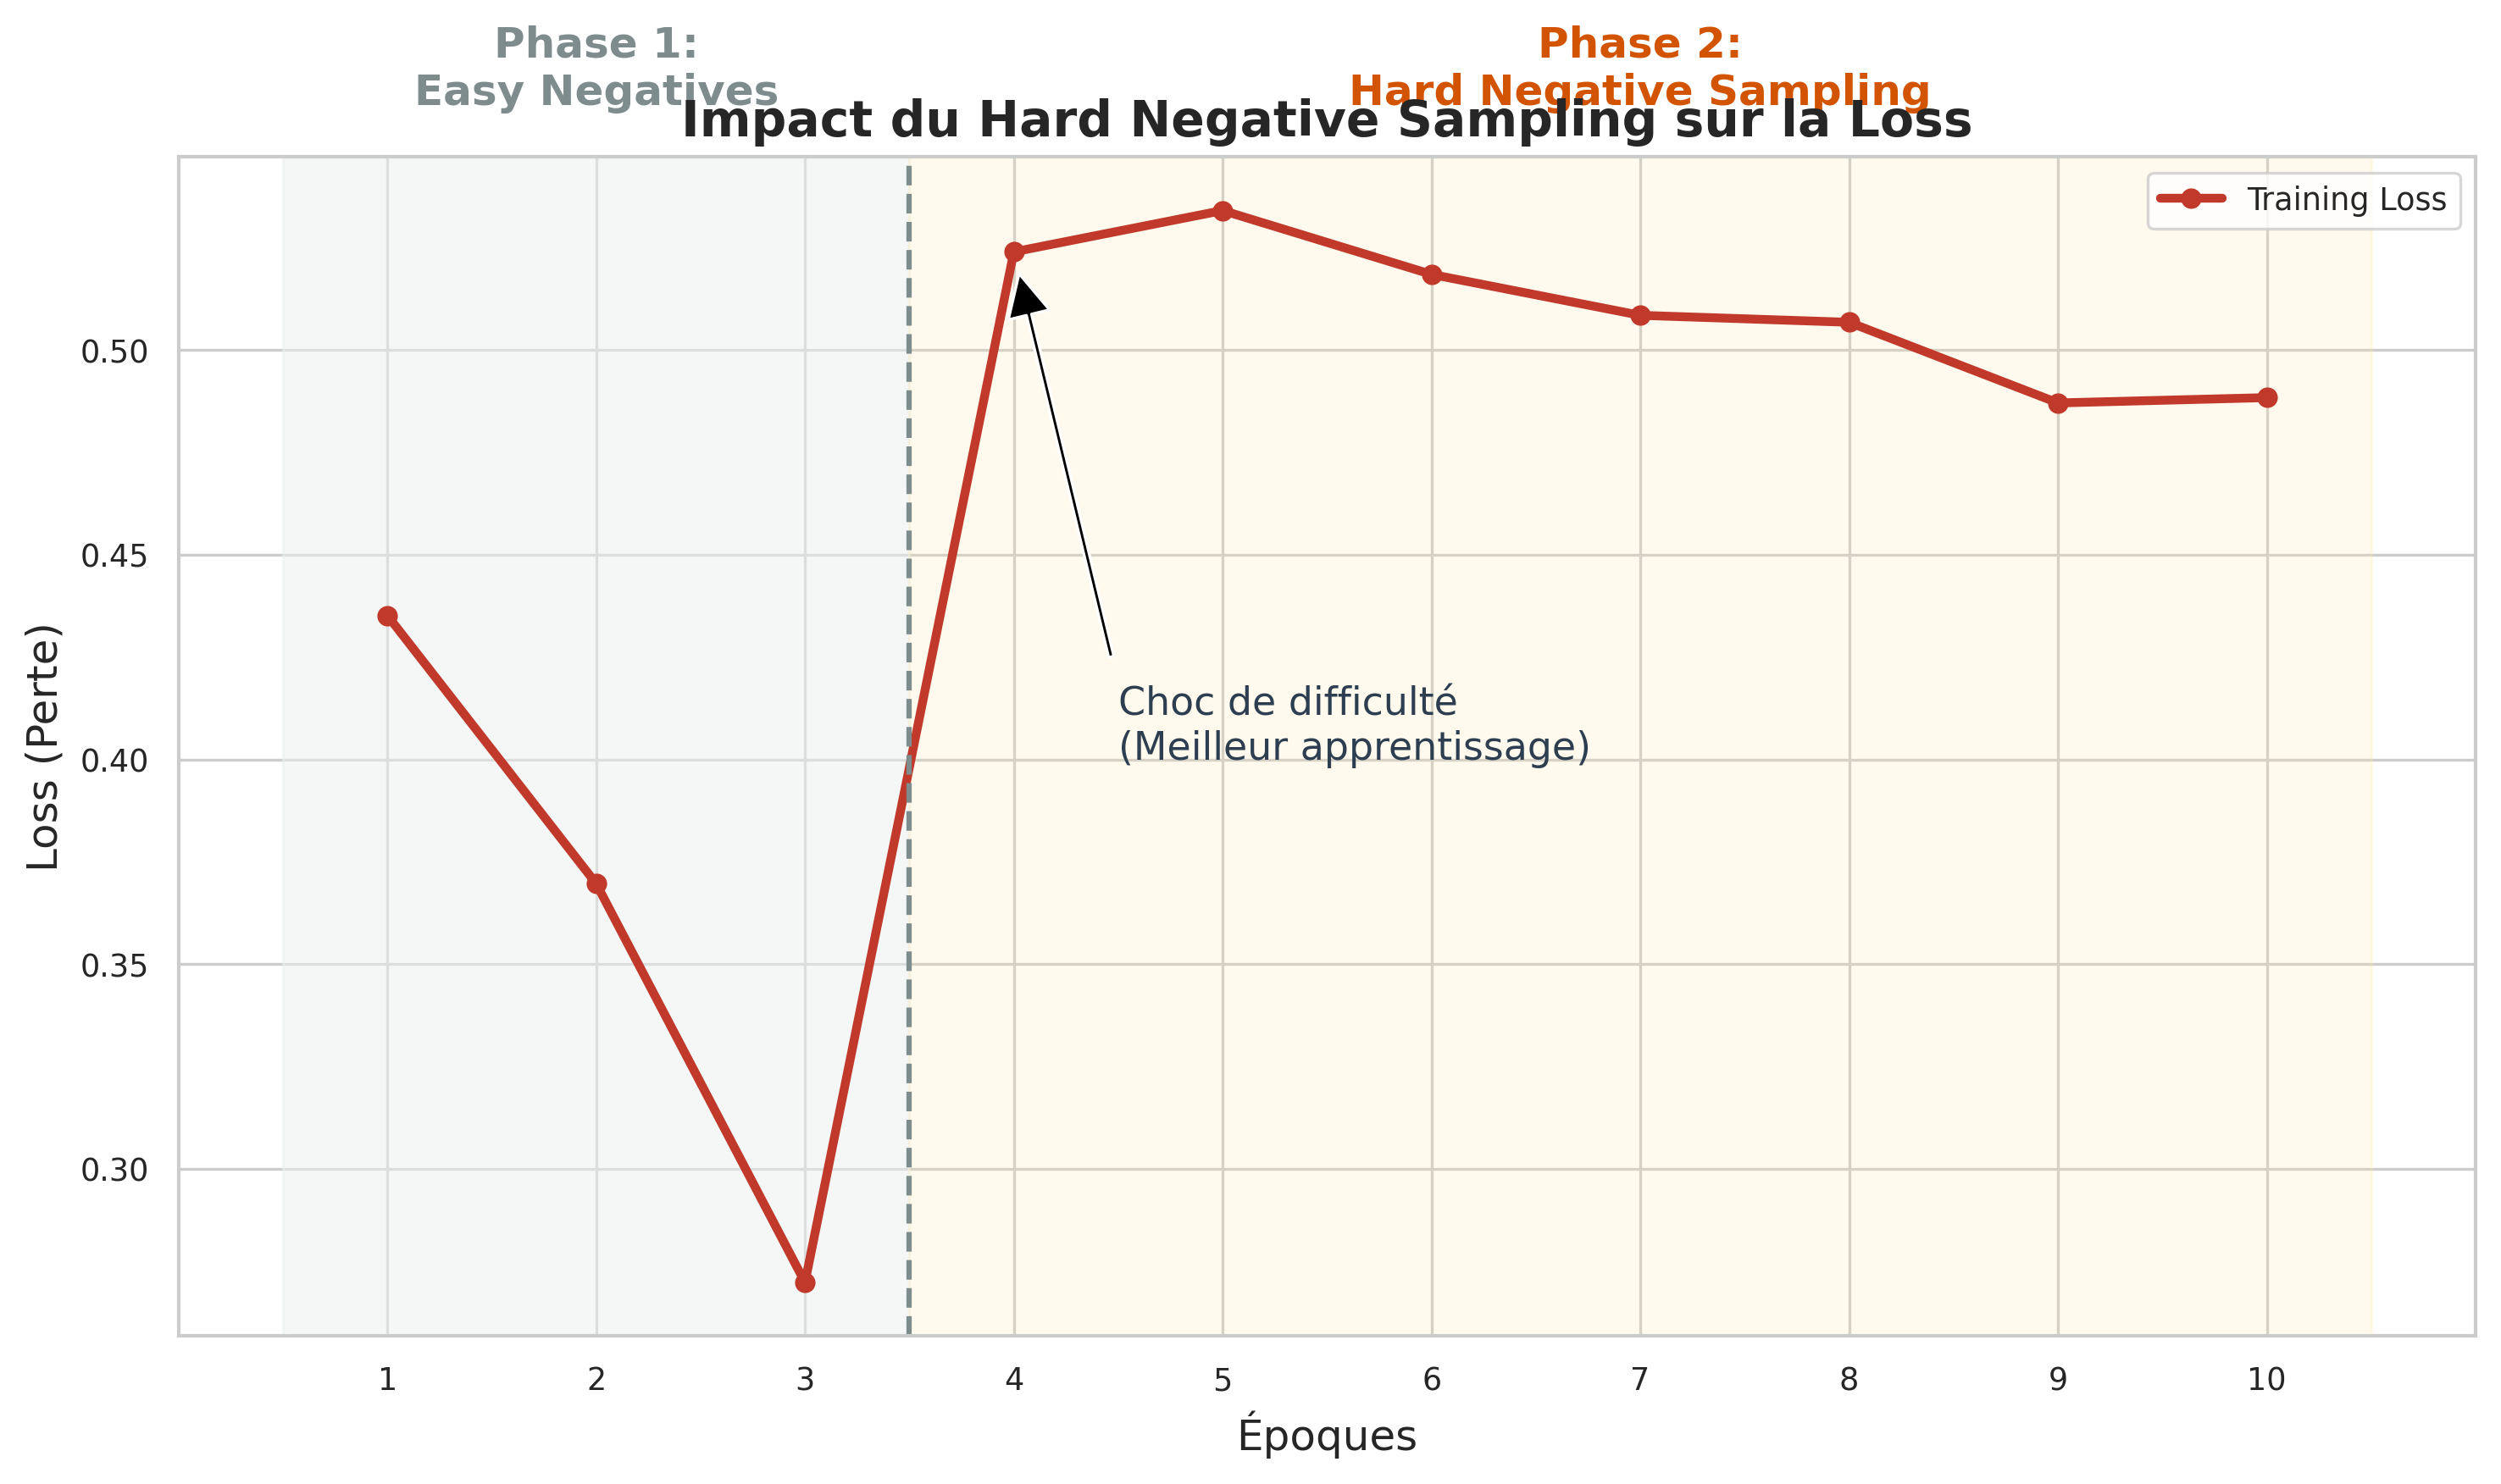

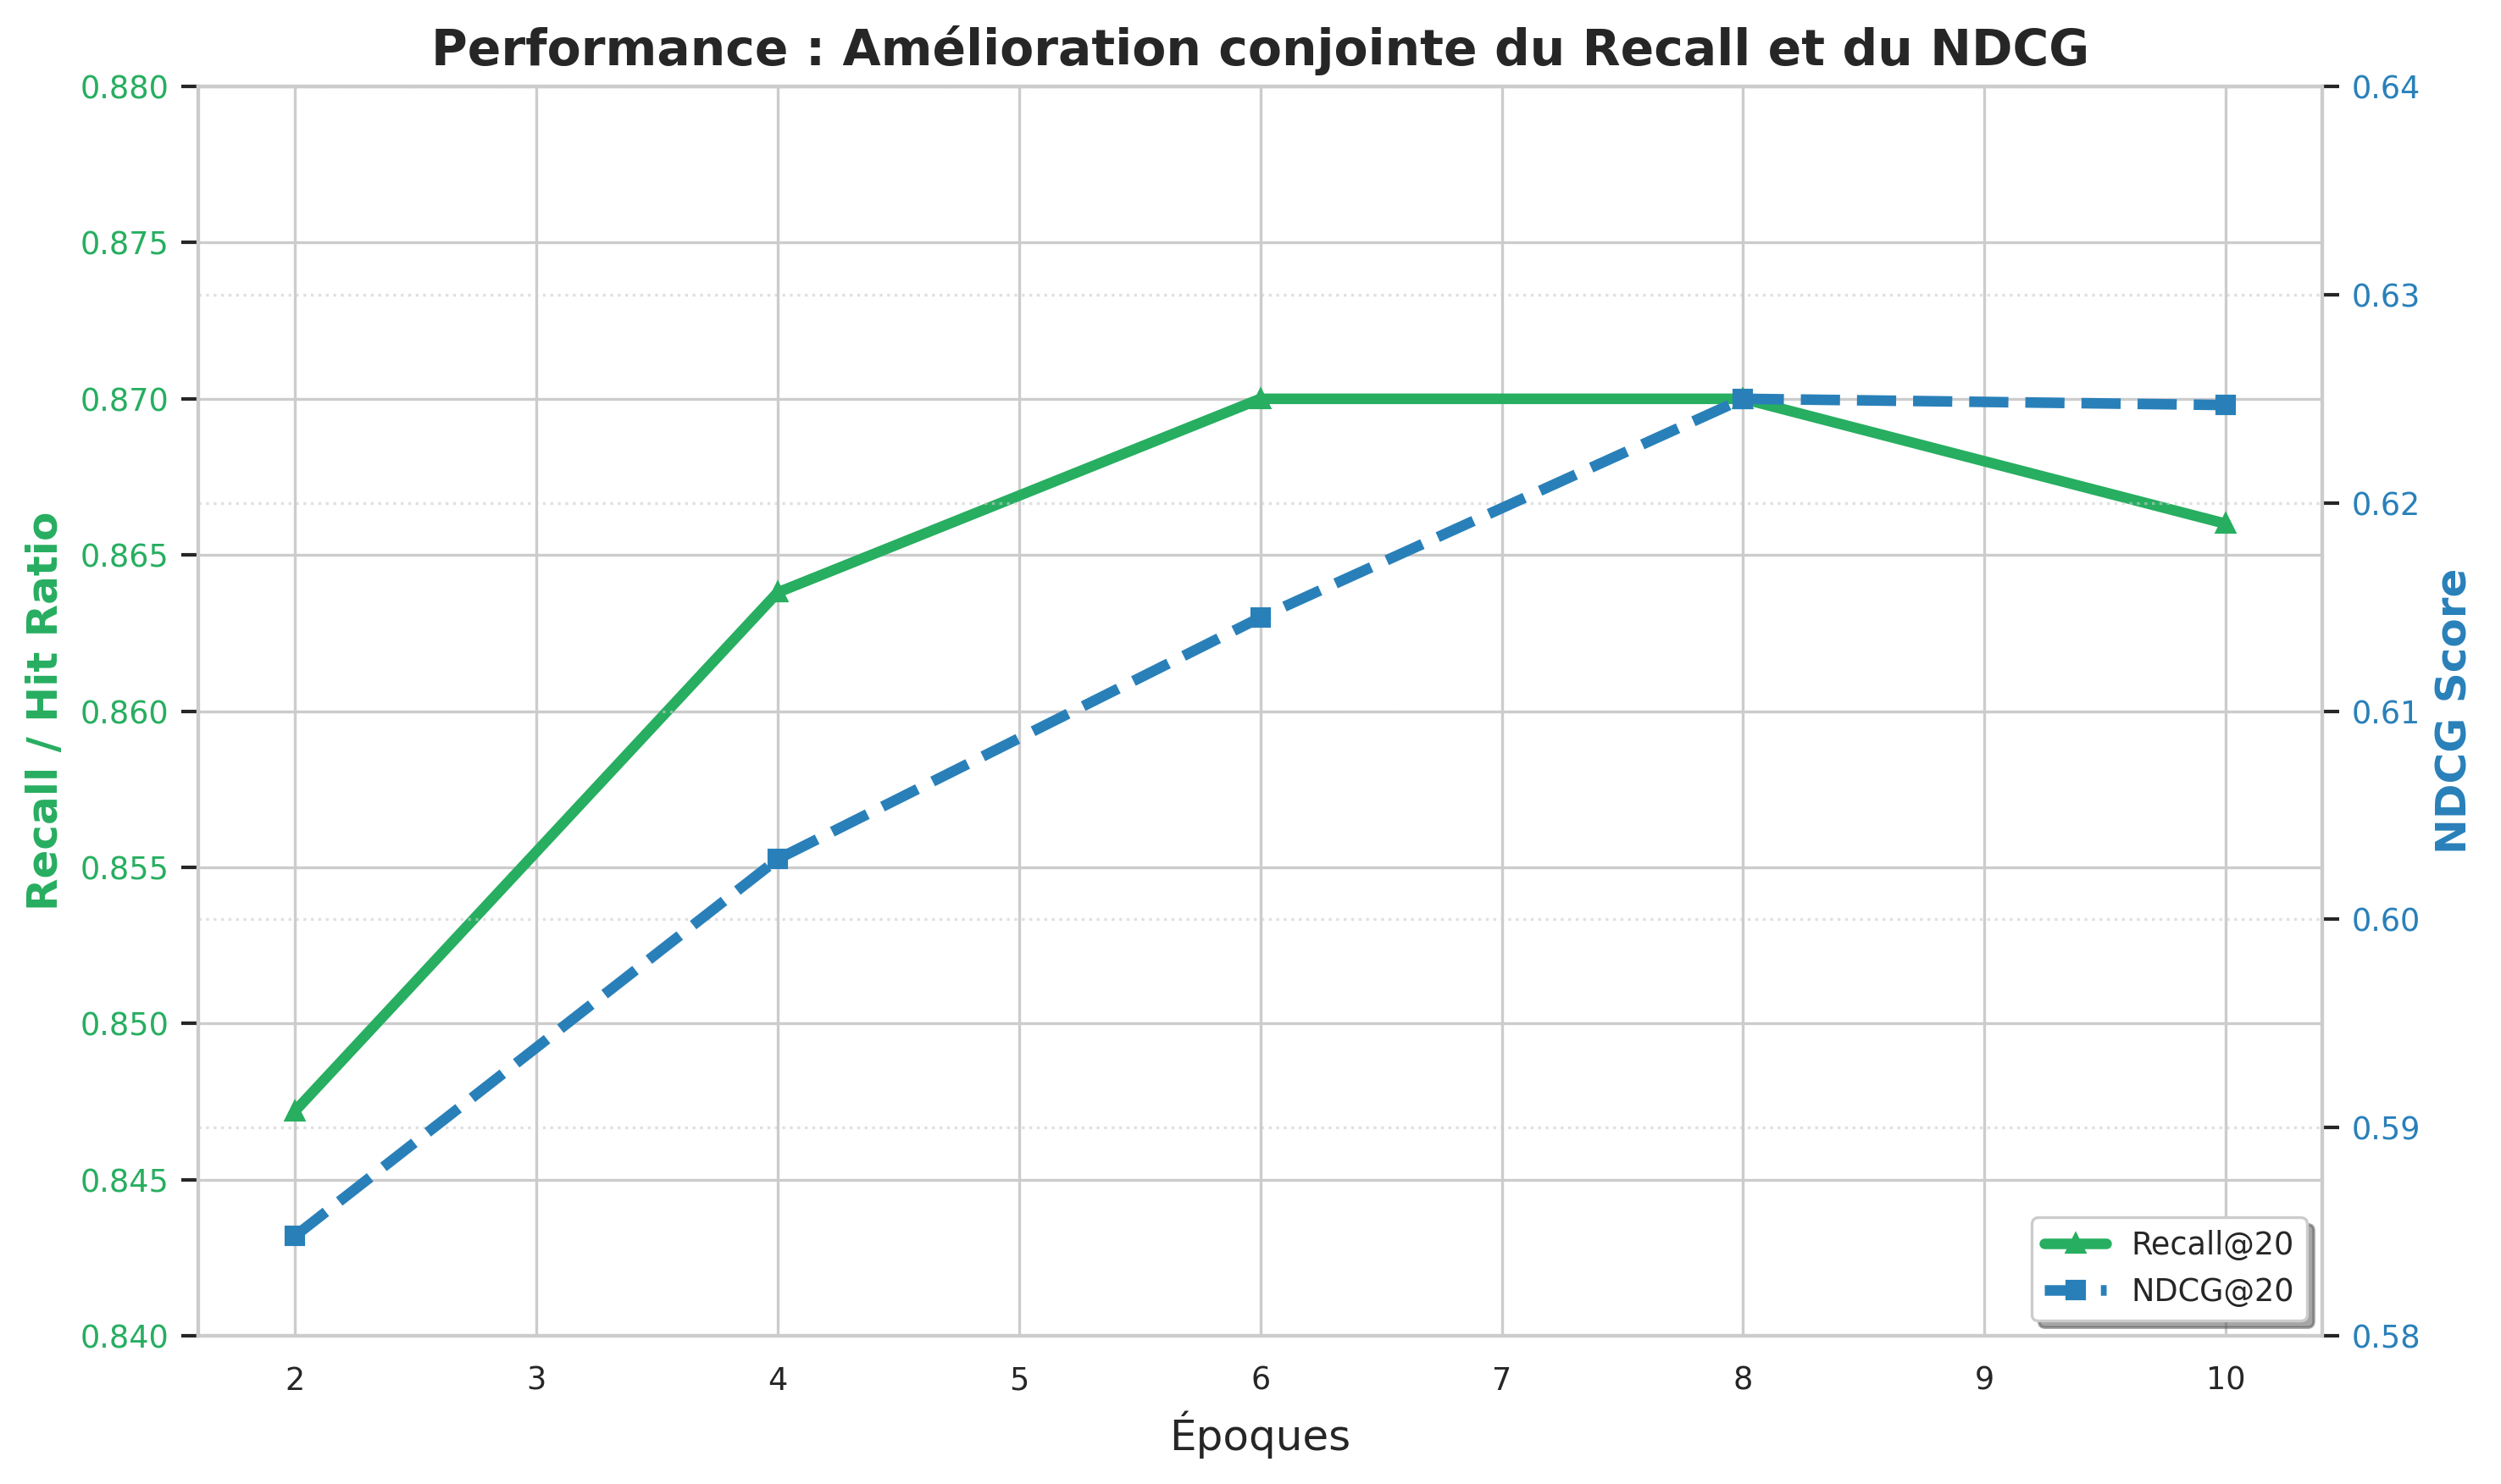

<Figure size 2400x1800 with 0 Axes>

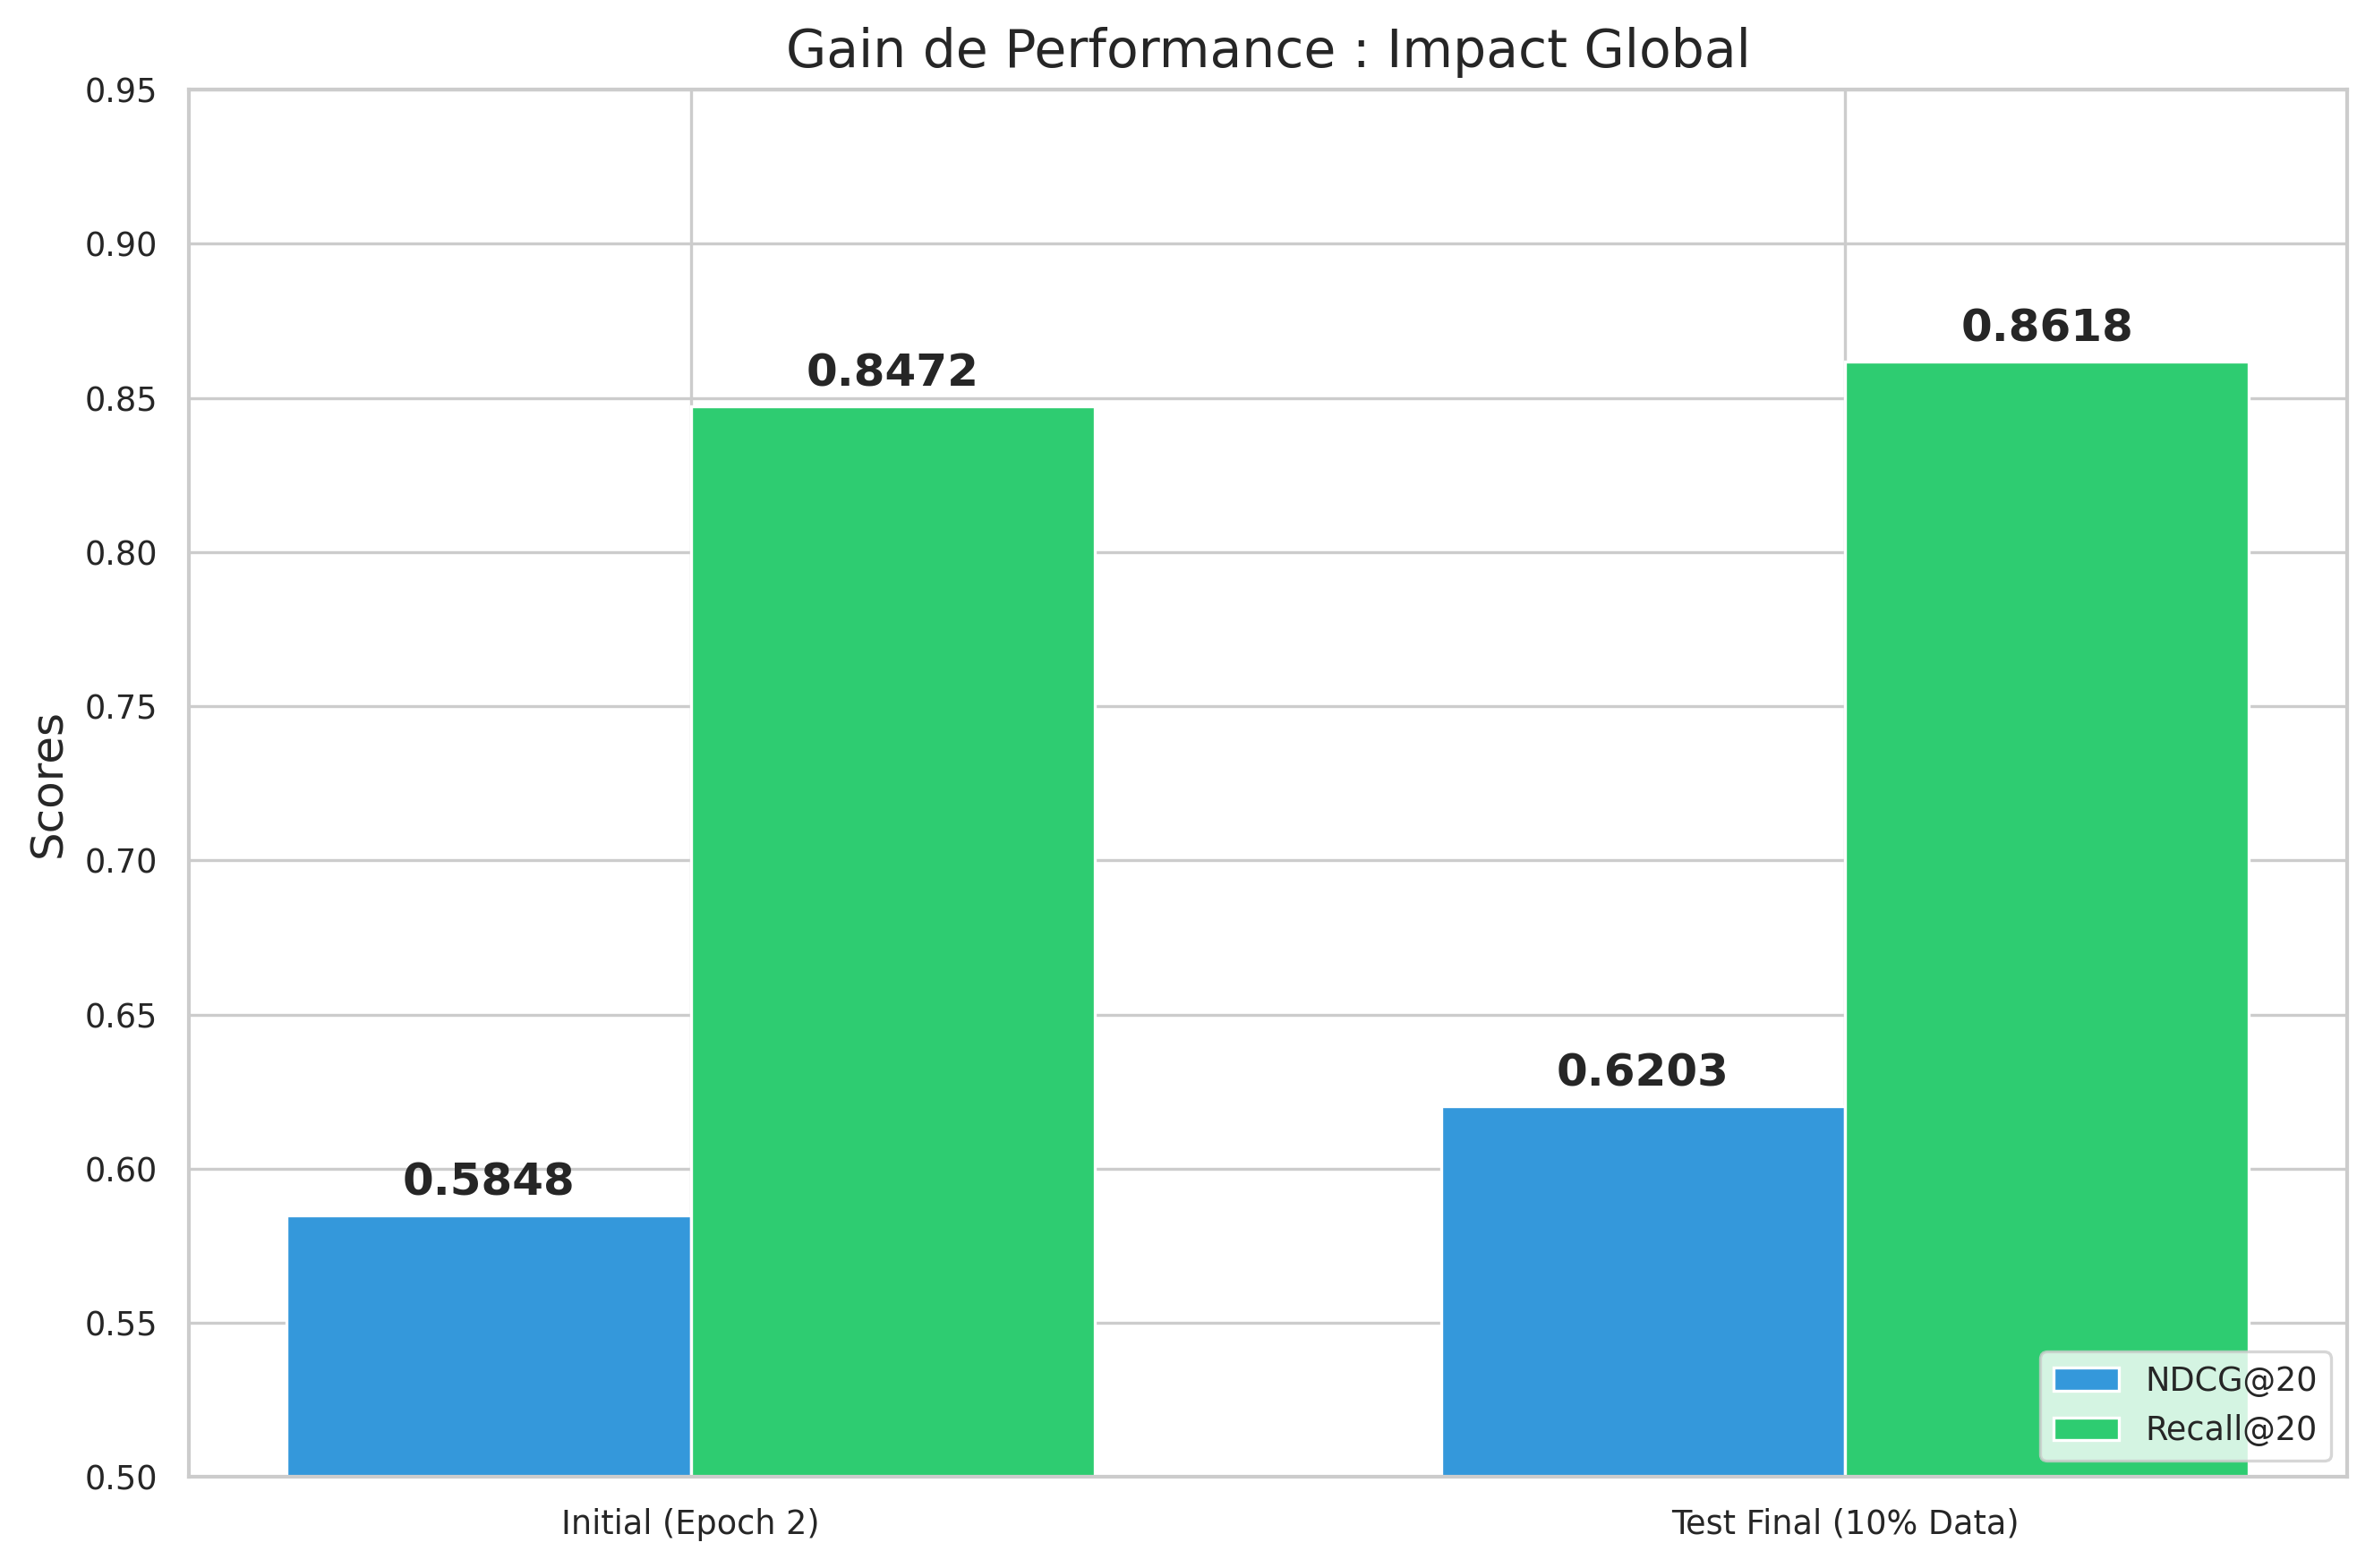

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. CONFIGURATION DU STYLE (Pour publication scientifique) ---
sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'figure.dpi': 300,        # Haute résolution
    'savefig.dpi': 300
})

# --- 2. VOS DONNÉES EXACTES (Mises à jour) ---
epochs = np.arange(1, 11)

# Loss (Le saut est visible à l'époque 4)
loss_values = [0.4352, 0.3697, 0.2723, 0.5240, 0.5341, 0.5185, 0.5085, 0.5068, 0.4871, 0.4884]

# Métriques Validation (Époques 2, 4, 6, 8, 10)
eval_epochs = [2, 4, 6, 8, 10]
# Note: HR = Recall ici
recall_values = [0.8472, 0.8638, 0.8700, 0.8700, 0.8660]
ndcg_values =   [0.5848, 0.6029, 0.6145, 0.6250, 0.6247]

# Résultats Finaux (Test Set - Les chiffres officiels)
final_recall = 0.8568
final_ndcg = 0.6168

# ==============================================================================
# FIGURE 1 : DYNAMIQUE D'APPRENTISSAGE (LOSS) & HARD NEGATIVES
# ==============================================================================
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='#c0392b', linewidth=2.5, label='Training Loss')

# Ligne verticale de séparation
plt.axvline(x=3.5, color='#7f8c8d', linestyle='--', linewidth=1.5)

# Zone colorée pour distinguer les phases
plt.axvspan(0.5, 3.5, color='#ecf0f1', alpha=0.5) # Zone Easy
plt.axvspan(3.5, 10.5, color='#ffeaa7', alpha=0.2) # Zone Hard

# Annotations textuelles
plt.text(2, 0.56, "Phase 1:\nEasy Negatives", ha='center', color='#7f8c8d', fontweight='bold')
plt.text(7, 0.56, "Phase 2:\nHard Negative Sampling", ha='center', color='#d35400', fontweight='bold')

# Flèche explicative sur le saut
plt.annotate('Choc de difficulté\n(Meilleur apprentissage)', xy=(4, 0.5240), xytext=(4.5, 0.40),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=11, color='#2c3e50')

plt.title("Impact du Hard Negative Sampling sur la Loss", fontweight='bold')
plt.xlabel("Époques")
plt.ylabel("Loss (Perte)")
plt.xticks(epochs)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("fig1_loss_dynamics.png")
plt.show()

# ==============================================================================
# FIGURE 2 : ÉVOLUTION DES MÉTRIQUES (RECALL & NDCG)
# ==============================================================================
plt.figure(figsize=(10, 6))

# Courbe Recall (Axe Y gauche)
ax1 = plt.gca()
line1 = ax1.plot(eval_epochs, recall_values, marker='^', linestyle='-', color='#27ae60', linewidth=3, label='Recall@20')
ax1.set_xlabel("Époques")
ax1.set_ylabel("Recall / Hit Ratio", color='#27ae60', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#27ae60')
# On ajuste un peu l'échelle pour centrer la courbe
ax1.set_ylim(0.84, 0.88)

# Courbe NDCG (Axe Y droit pour mieux voir l'échelle)
ax2 = ax1.twinx()
line2 = ax2.plot(eval_epochs, ndcg_values, marker='s', linestyle='--', color='#2980b9', linewidth=3, label='NDCG@20')
ax2.set_ylabel("NDCG Score", color='#2980b9', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#2980b9')
ax2.set_ylim(0.58, 0.64)

# Légende combinée
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='lower right', frameon=True, shadow=True)

plt.title("Performance : Amélioration conjointe du Recall et du NDCG", fontweight='bold')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig("fig2_metrics_evolution.png")
plt.show()

# ==============================================================================
# FIGURE 3 : SYNTHÈSE FINALE (BAR CHART)
# ==============================================================================
plt.figure(figsize=(8, 6))

# Données pour la comparaison
labels = ['Initial (Epoch 2)', 'Test Final (10% Data)']
# On compare le début de l'entraînement vs le résultat final réel
final_metrics_recall = [recall_values[0], final_recall]
final_metrics_ndcg = [ndcg_values[0], final_ndcg]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 6))
rects1 = ax.bar(x - width/2, final_metrics_ndcg, width, label='NDCG@20', color='#3498db')
rects2 = ax.bar(x + width/2, final_metrics_recall, width, label='Recall@20', color='#2ecc71')

ax.set_ylabel('Scores')
ax.set_title('Gain de Performance : Impact Global')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')
ax.set_ylim(0.5, 0.95)

# Fonction pour ajouter les labels sur les barres
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # offset vertical
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig("fig3_final_results.png")
plt.show()

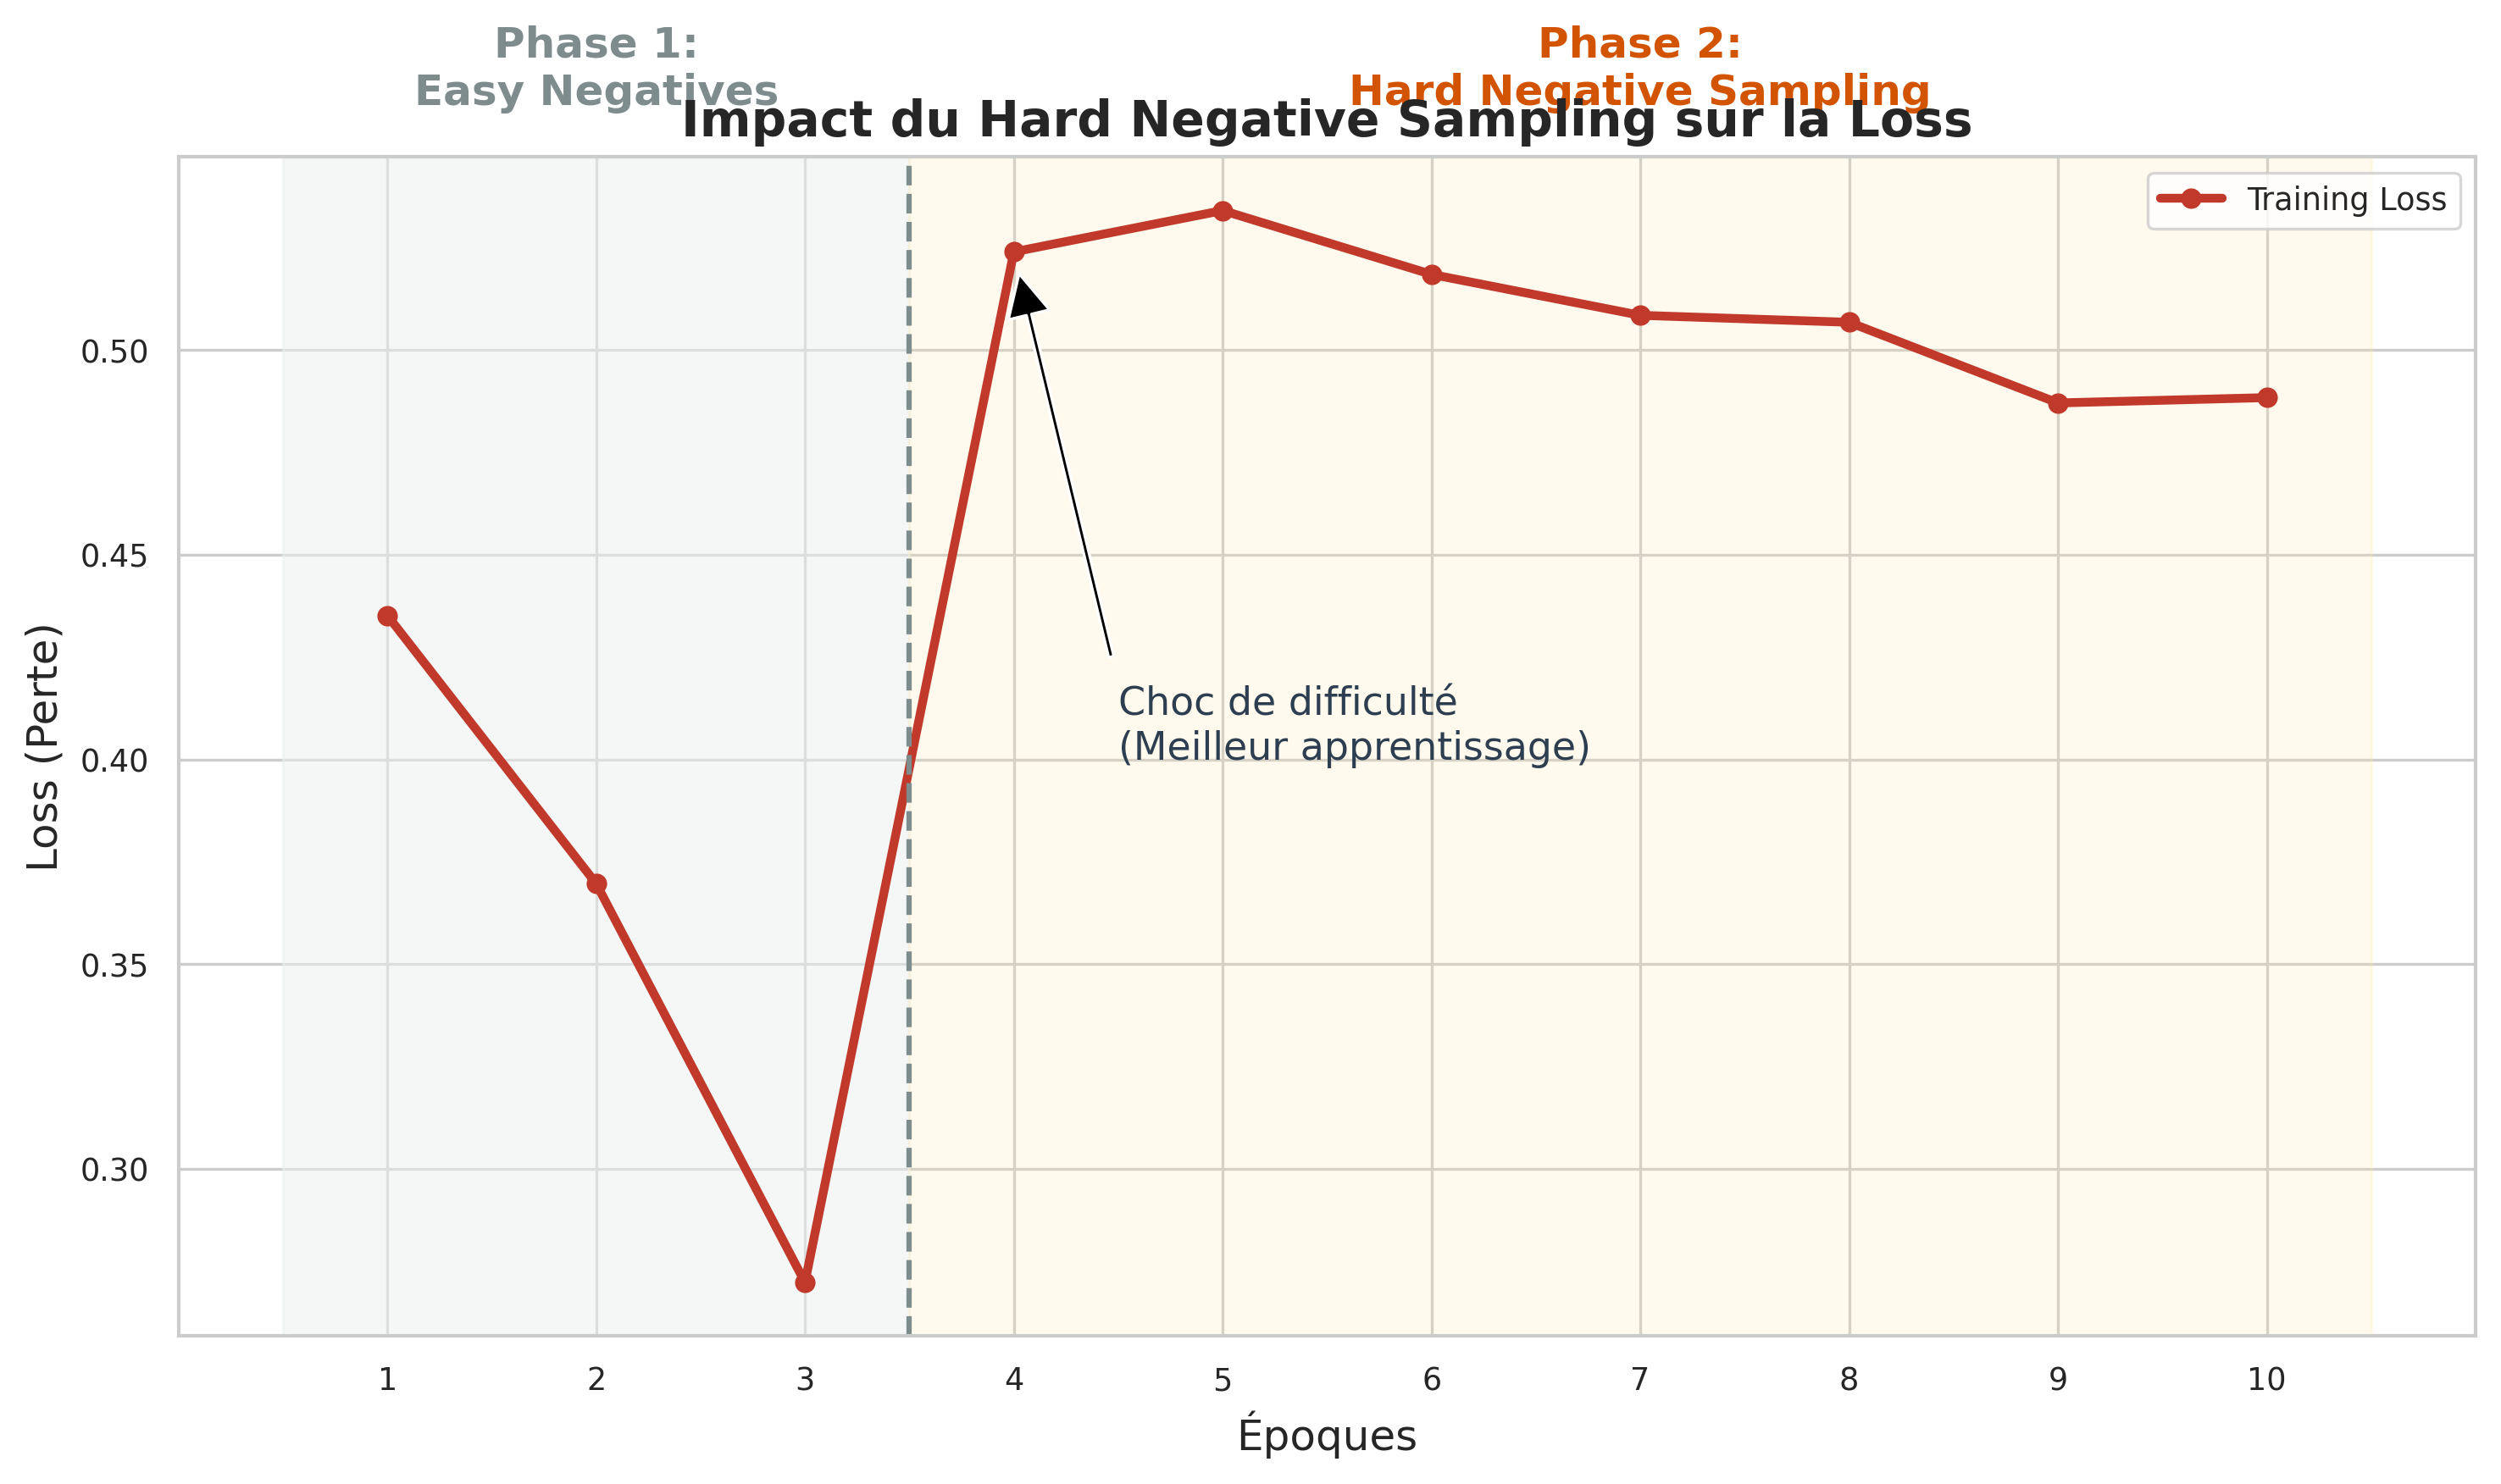

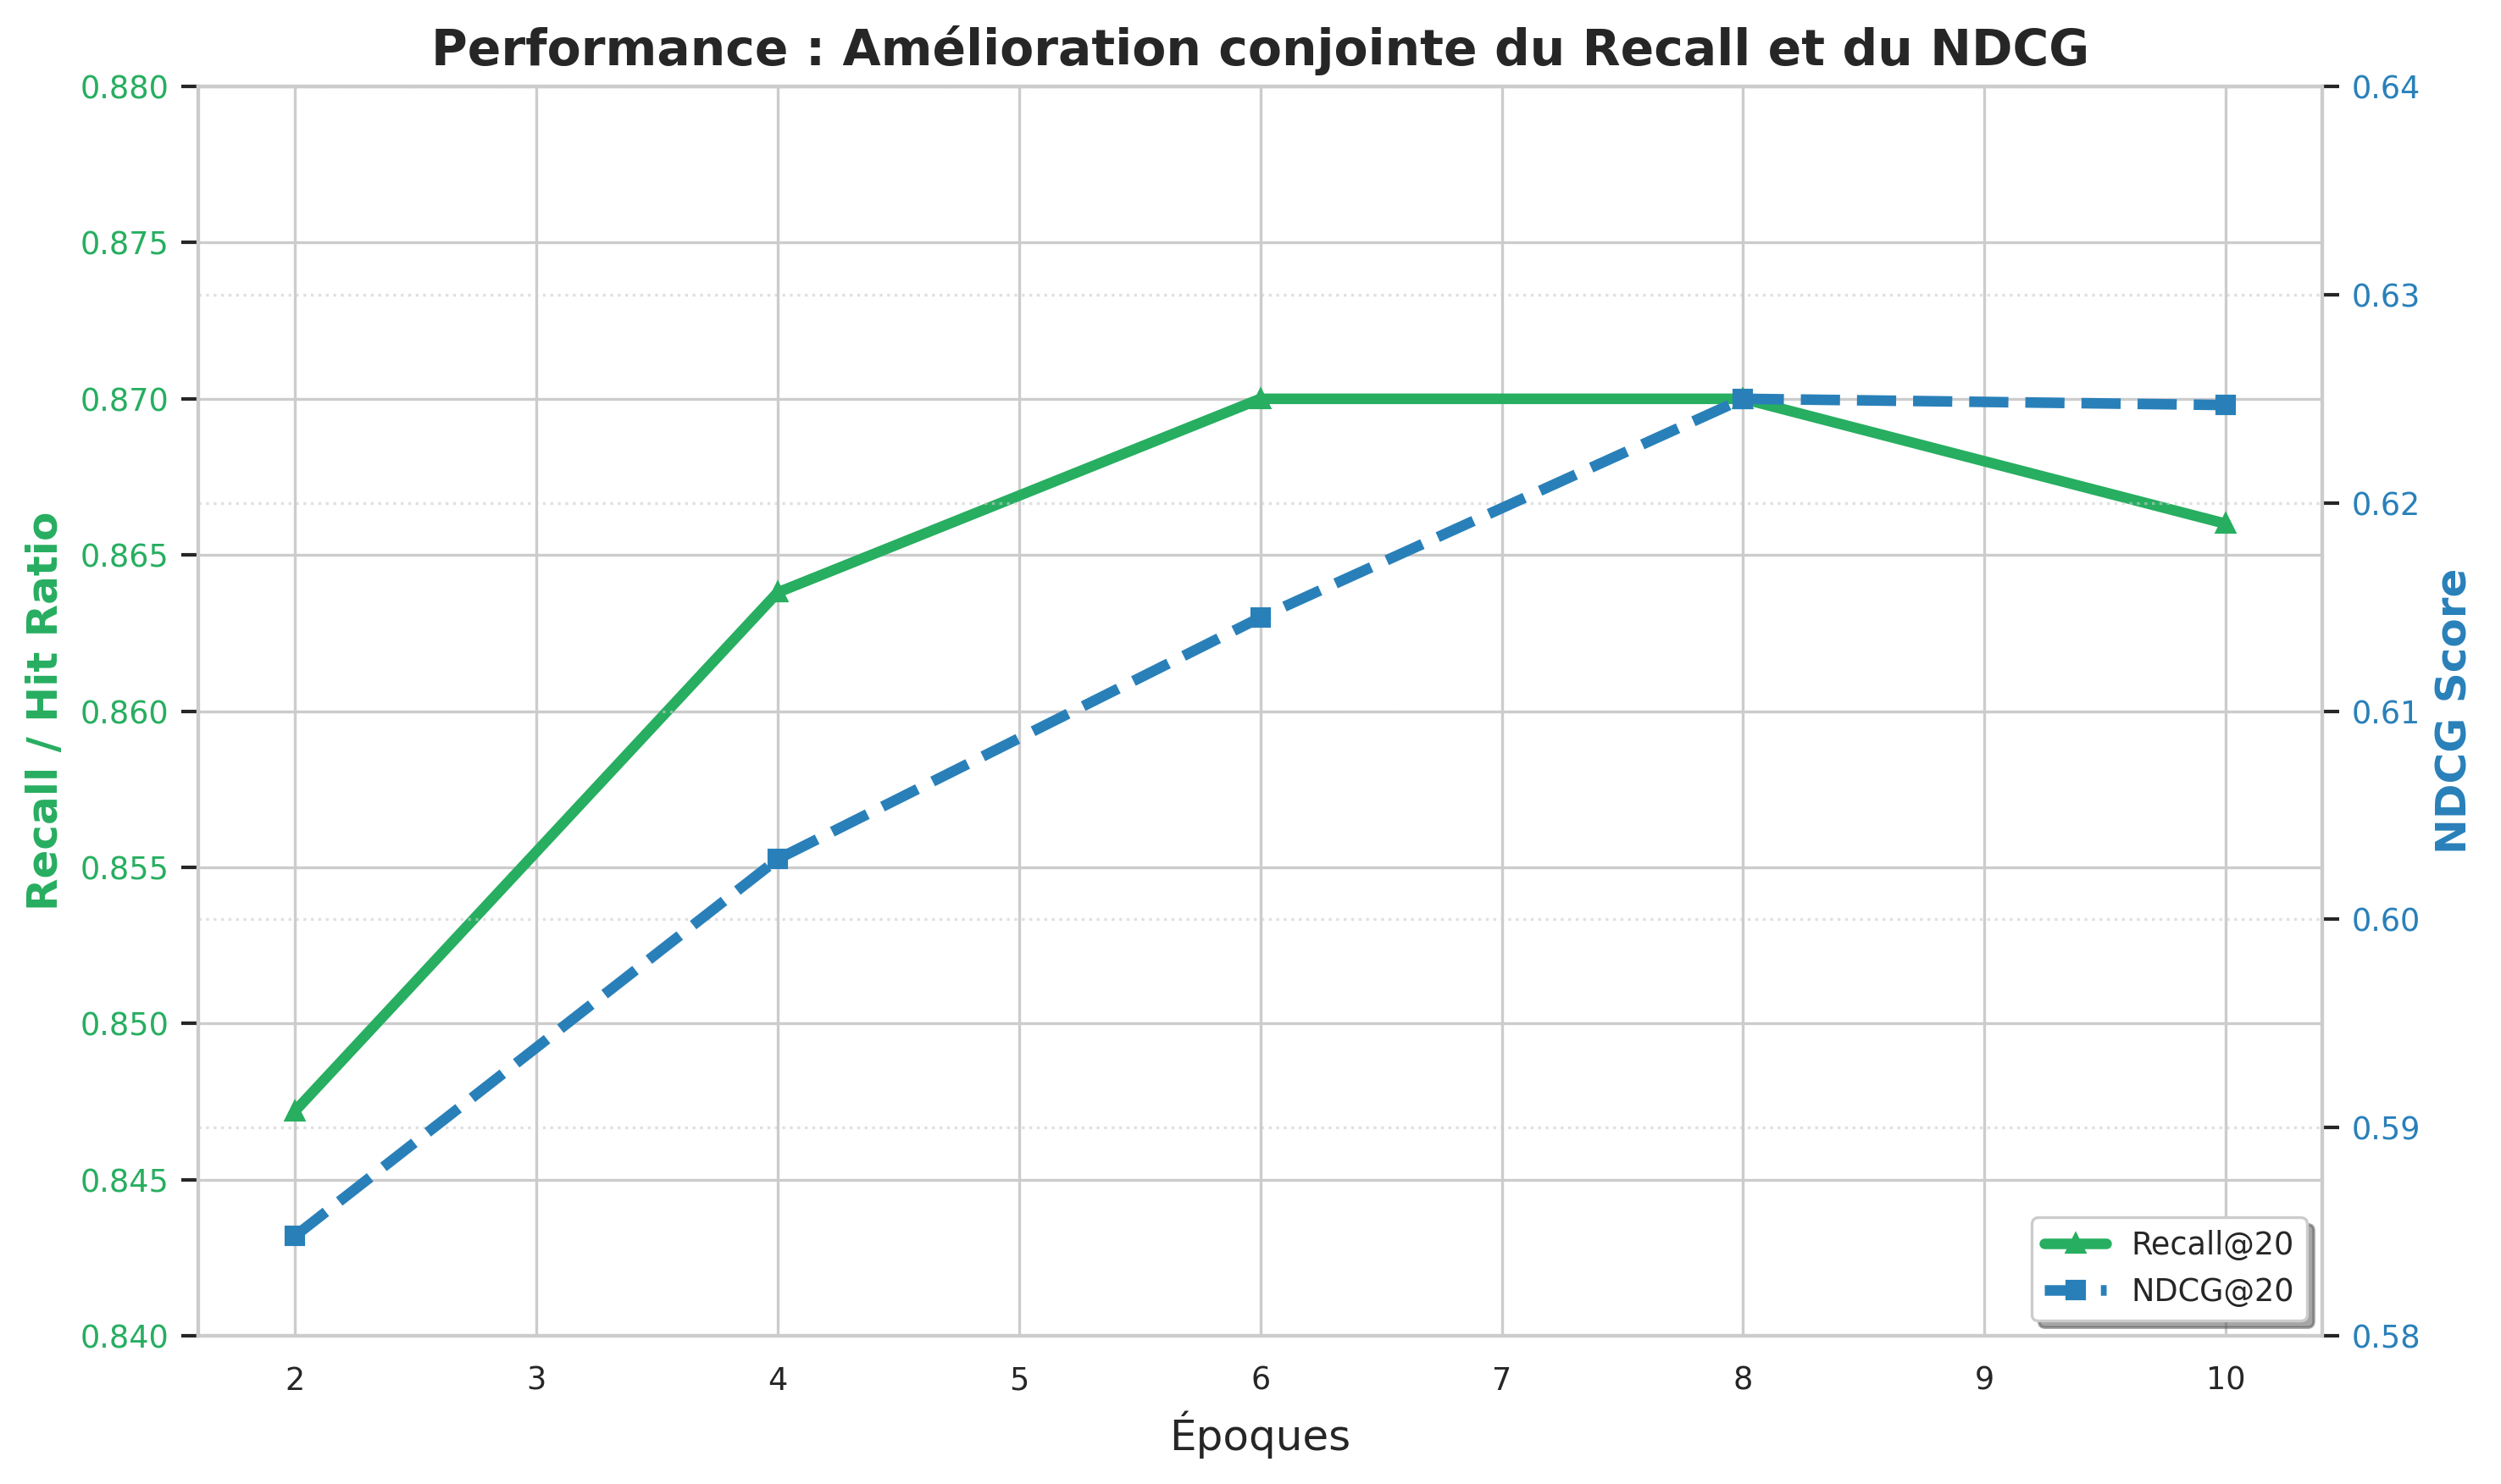

<Figure size 2400x1800 with 0 Axes>

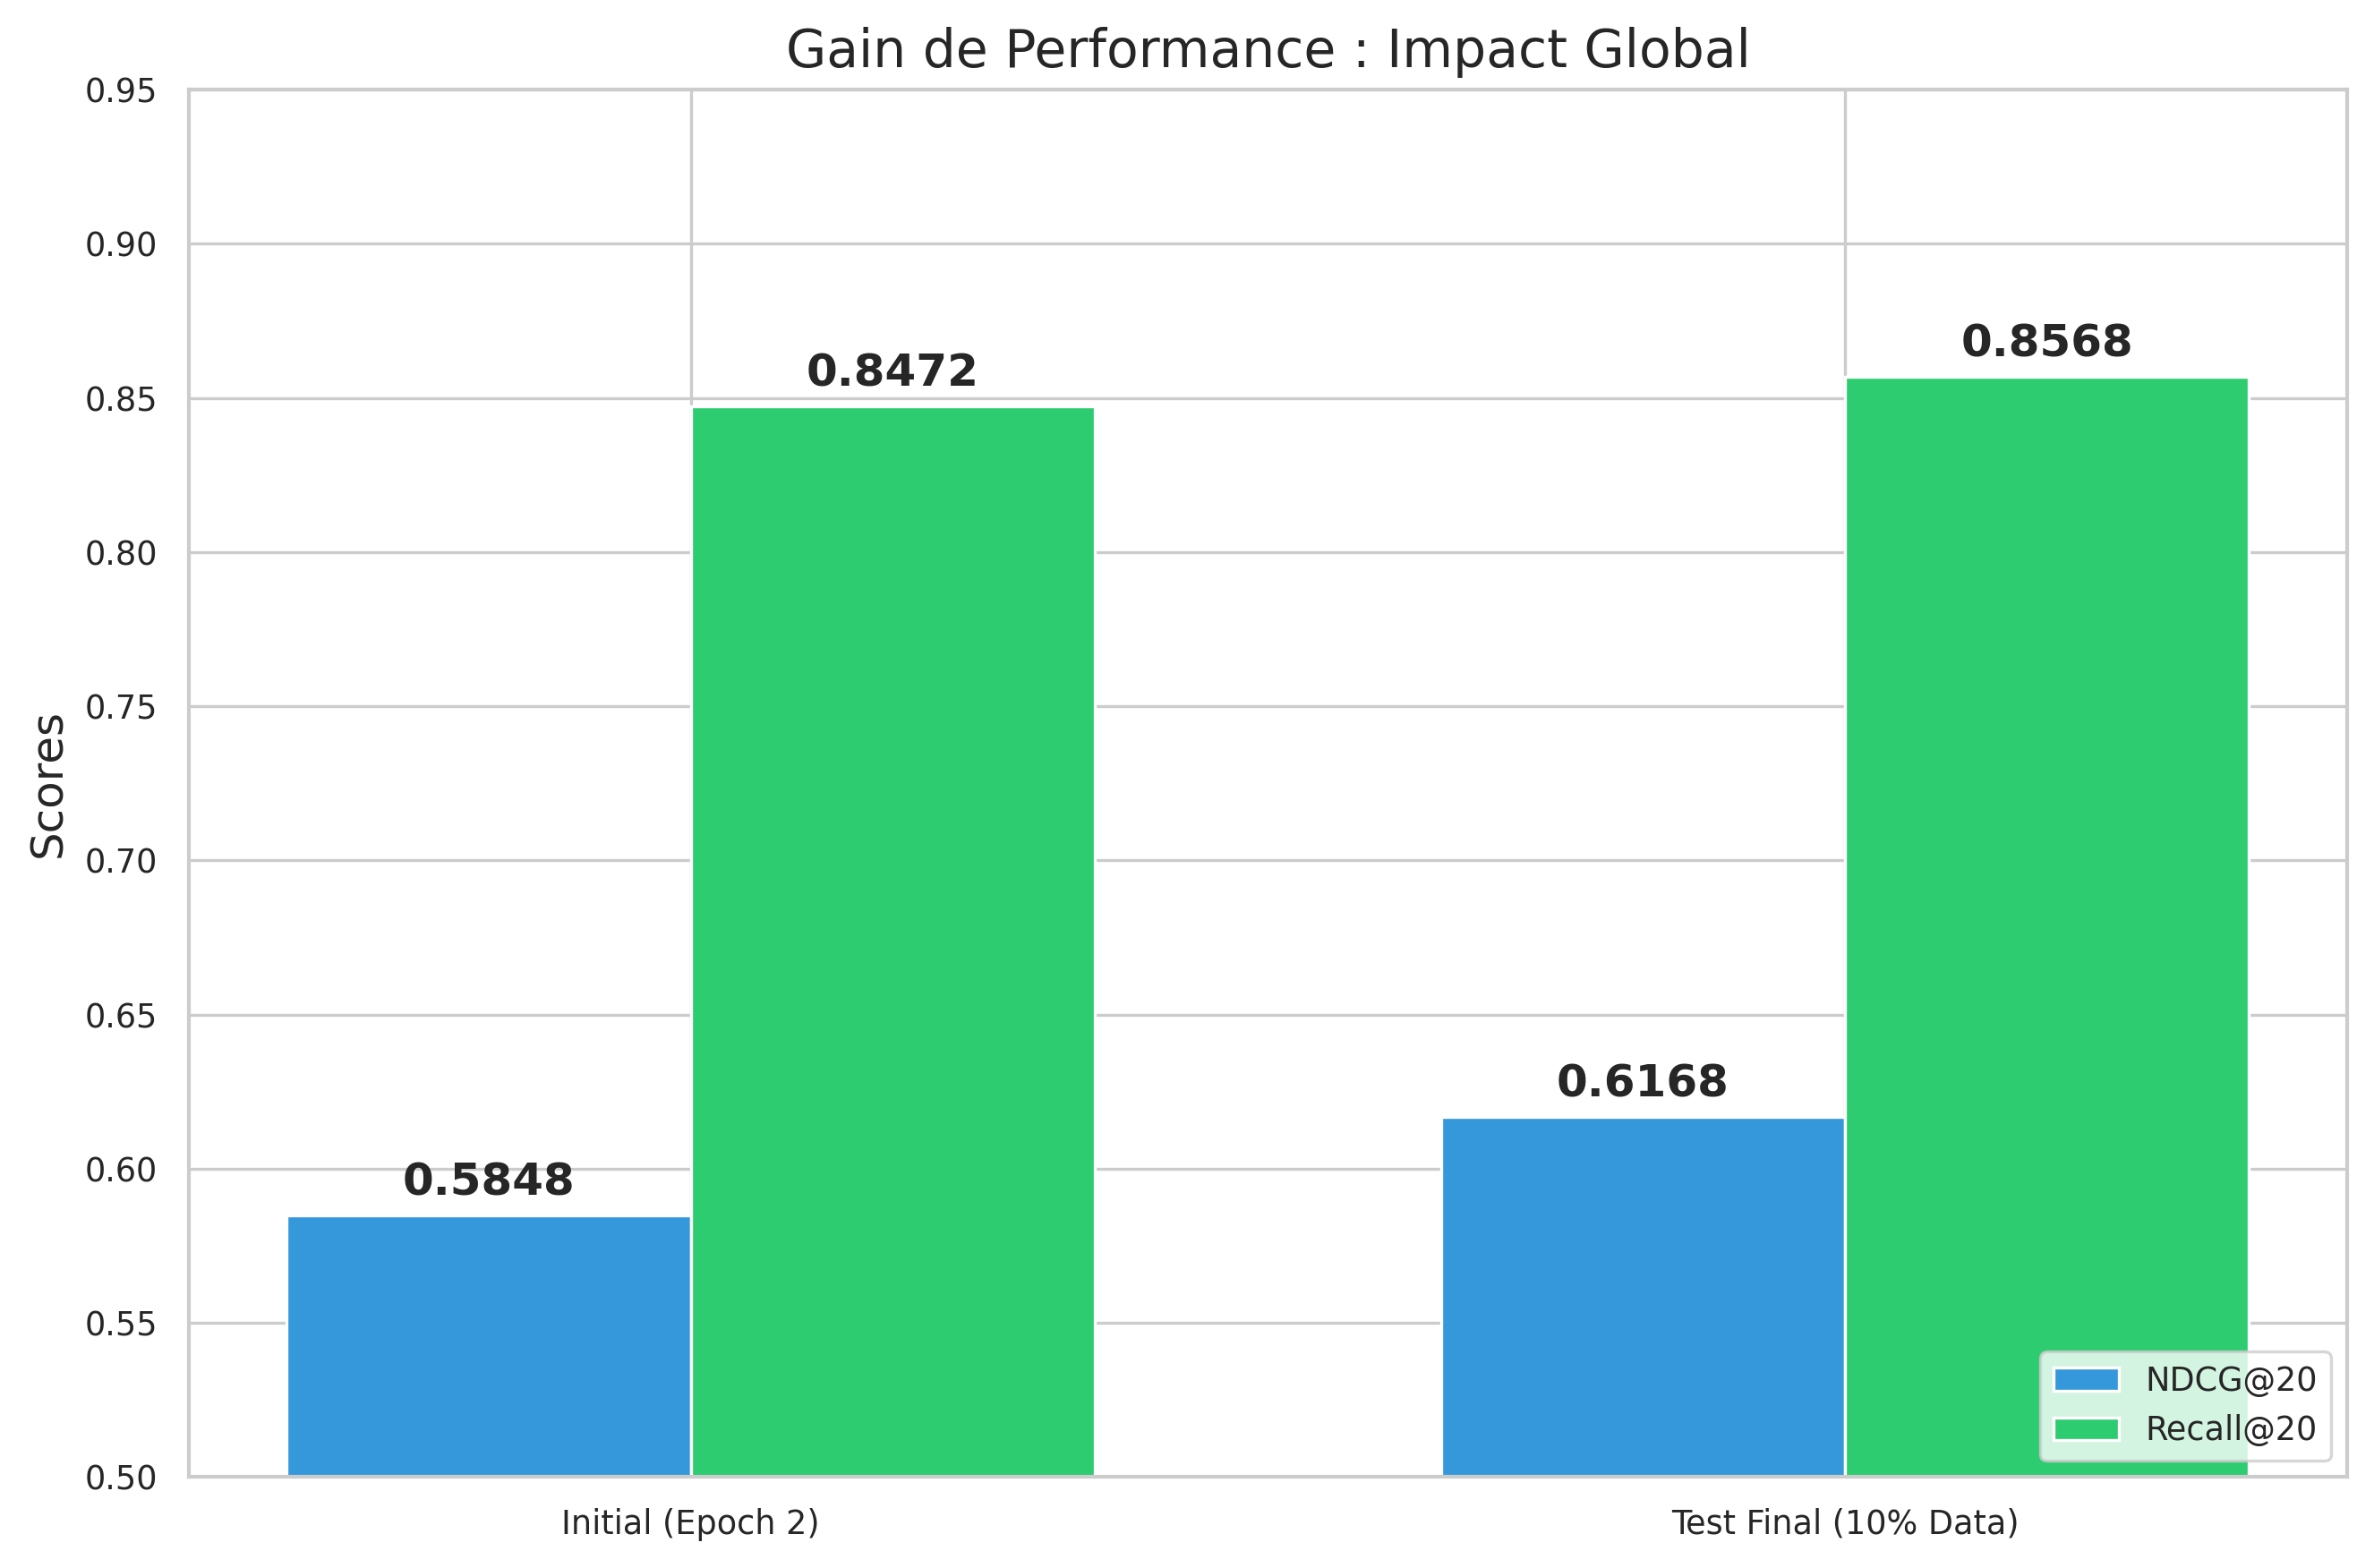

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. CONFIGURATION DU STYLE (Pour publication scientifique) ---
sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'figure.dpi': 300,        # Haute résolution
    'savefig.dpi': 300
})

# --- 2. VOS DONNÉES EXACTES (Mises à jour) ---
epochs = np.arange(1, 11)

# Loss (Le saut est visible à l'époque 4)
loss_values = [0.4352, 0.3697, 0.2723, 0.5240, 0.5341, 0.5185, 0.5085, 0.5068, 0.4871, 0.4884]

# Métriques Validation (Époques 2, 4, 6, 8, 10)
eval_epochs = [2, 4, 6, 8, 10]
# Note: HR = Recall ici
recall_values = [0.8472, 0.8638, 0.8700, 0.8700, 0.8660]
ndcg_values =   [0.5848, 0.6029, 0.6145, 0.6250, 0.6247]

# Résultats Finaux (Test Set - Les chiffres officiels)
final_recall = 0.8568
final_ndcg = 0.6168

# ==============================================================================
# FIGURE 1 : DYNAMIQUE D'APPRENTISSAGE (LOSS) & HARD NEGATIVES
# ==============================================================================
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='#c0392b', linewidth=2.5, label='Training Loss')

# Ligne verticale de séparation
plt.axvline(x=3.5, color='#7f8c8d', linestyle='--', linewidth=1.5)

# Zone colorée pour distinguer les phases
plt.axvspan(0.5, 3.5, color='#ecf0f1', alpha=0.5) # Zone Easy
plt.axvspan(3.5, 10.5, color='#ffeaa7', alpha=0.2) # Zone Hard

# Annotations textuelles
plt.text(2, 0.56, "Phase 1:\nEasy Negatives", ha='center', color='#7f8c8d', fontweight='bold')
plt.text(7, 0.56, "Phase 2:\nHard Negative Sampling", ha='center', color='#d35400', fontweight='bold')

# Flèche explicative sur le saut
plt.annotate('Choc de difficulté\n(Meilleur apprentissage)', xy=(4, 0.5240), xytext=(4.5, 0.40),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=11, color='#2c3e50')

plt.title("Impact du Hard Negative Sampling sur la Loss", fontweight='bold')
plt.xlabel("Époques")
plt.ylabel("Loss (Perte)")
plt.xticks(epochs)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("fig1_loss_dynamics.png")
plt.show()

# ==============================================================================
# FIGURE 2 : ÉVOLUTION DES MÉTRIQUES (RECALL & NDCG)
# ==============================================================================
plt.figure(figsize=(10, 6))

# Courbe Recall (Axe Y gauche)
ax1 = plt.gca()
line1 = ax1.plot(eval_epochs, recall_values, marker='^', linestyle='-', color='#27ae60', linewidth=3, label='Recall@20')
ax1.set_xlabel("Époques")
ax1.set_ylabel("Recall / Hit Ratio", color='#27ae60', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#27ae60')
# On ajuste un peu l'échelle pour centrer la courbe
ax1.set_ylim(0.84, 0.88)

# Courbe NDCG (Axe Y droit pour mieux voir l'échelle)
ax2 = ax1.twinx()
line2 = ax2.plot(eval_epochs, ndcg_values, marker='s', linestyle='--', color='#2980b9', linewidth=3, label='NDCG@20')
ax2.set_ylabel("NDCG Score", color='#2980b9', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#2980b9')
ax2.set_ylim(0.58, 0.64)

# Légende combinée
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='lower right', frameon=True, shadow=True)

plt.title("Performance : Amélioration conjointe du Recall et du NDCG", fontweight='bold')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig("fig2_metrics_evolution.png")
plt.show()

# ==============================================================================
# FIGURE 3 : SYNTHÈSE FINALE (BAR CHART)
# ==============================================================================
plt.figure(figsize=(8, 6))

# Données pour la comparaison
labels = ['Initial (Epoch 2)', 'Test Final (10% Data)']
# On compare le début de l'entraînement vs le résultat final réel
final_metrics_recall = [recall_values[0], final_recall]
final_metrics_ndcg = [ndcg_values[0], final_ndcg]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 6))
rects1 = ax.bar(x - width/2, final_metrics_ndcg, width, label='NDCG@20', color='#3498db')
rects2 = ax.bar(x + width/2, final_metrics_recall, width, label='Recall@20', color='#2ecc71')

ax.set_ylabel('Scores')
ax.set_title('Gain de Performance : Impact Global')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')
ax.set_ylim(0.5, 0.95)

# Fonction pour ajouter les labels sur les barres
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # offset vertical
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig("fig3_final_results.png")
plt.show()